In [1]:
import sys
import os

if '..' not in sys.path:
    sys.path.append('..')

%load_ext autoreload
%autoreload 2

# Import Data

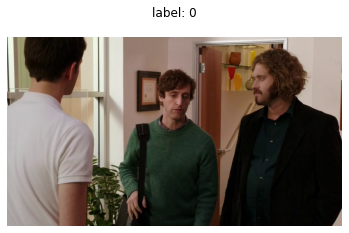

In [42]:
from conv_recognition.dataset import UcoDataset
import matplotlib.pyplot as plt

data = UcoDataset('../data/ucolaeodb', 'sv01')
img, label = data[0]

plt.imshow(img.permute(1,2,0))
plt.title(f'label: {label}')
plt.axis('off')
plt.show()

# Face Detection

In [3]:
from face_detection import RetinaFace
detector = RetinaFace(0)

0.99988294
0.999373


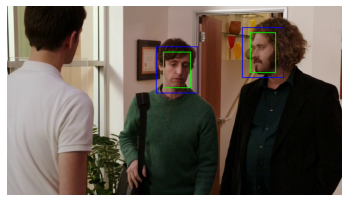

2 found


In [44]:
import cv2 
from copy import copy

img_numpy = copy(img.permute(1,2,0).cpu().numpy())
faces = detector(img_numpy)

face_tensors = []
for box, landmarks, score in faces:
    if score < 0.9:
        continue
    print(score)
    x_min = int(box[0])
    y_min = int(box[1])
    x_max = int(box[2])
    y_max = int(box[3])

    bbox_width = abs(x_max - x_min)
    bbox_height = abs(y_max - y_min)

    x_min2 = max(0, x_min-int(0.2*bbox_height))
    y_min2 = max(0, y_min-int(0.2*bbox_width))
    x_max2 = x_max+int(0.2*bbox_height)
    y_max2 = y_max+int(0.2*bbox_width)

    face_tensors.append(img[:, y_min:y_max, x_min:x_max])

    cv2.rectangle(img_numpy, (x_min, y_min), (x_max, y_max), (0,255,0), 2)
    cv2.rectangle(img_numpy, (x_min2, y_min2), (x_max2, y_max2), (0,0,255), 2)

plt.imshow(img_numpy)
plt.axis('off')
plt.show()
print(f'{len(face_tensors)} found')

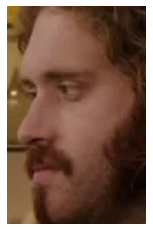

In [5]:
plt.imshow(face_tensors[1].permute(1,2,0))
plt.axis('off')
plt.show()

# Detect Head Pose

In [17]:
if f'../extern/6DRepNet' not in sys.path:
    sys.path.append(f'../extern/6DRepNet')

from model import SixDRepNet
from torchvision import transforms
import torch
import os

gpu_id = 0

In [21]:
snapshot_path = '../data/models/6DRepNet_300W_LP_AFLW2000.pth'
transformations = transforms.Compose([transforms.Resize(224),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
model = SixDRepNet(backbone_name='RepVGG-B1g2',
                   backbone_file='',
                   deploy=True,
                   pretrained=False)
detector = RetinaFace(gpu_id=gpu_id)

saved_state_dict = torch.load(snapshot_path, map_location='cpu')
if 'model_state_dict' in saved_state_dict:
    model.load_state_dict(saved_state_dict['model_state_dict'])
else:
    model.load_state_dict(saved_state_dict)

model.cuda(gpu_id)
model.eval()

print('successfully loaded models')

successfully loaded models


0.99988294
0.999373
0.06428118
0.0223678


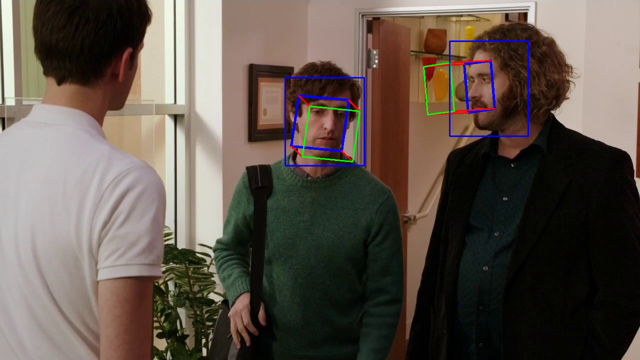

In [54]:
from PIL import Image
import utils
import numpy as np

def get_poses(frame):
    faces = detector(frame)
    for box, landmarks, score in faces:
        print(score)
        if score < 0.95:
            continue
        x_min = int(box[0])
        y_min = int(box[1])
        x_max = int(box[2])
        y_max = int(box[3])
        bbox_width = abs(x_max - x_min)
        bbox_height = abs(y_max - y_min)

        x_min = max(0, x_min-int(0.2*bbox_height))
        y_min = max(0, y_min-int(0.2*bbox_width))
        x_max = x_max+int(0.2*bbox_height)
        y_max = y_max+int(0.2*bbox_width)

        img = frame[y_min:y_max, x_min:x_max]
        img = Image.fromarray(img)
        img = img.convert('RGB')
        img = transformations(img)

        img = torch.Tensor(img[None, :]).cuda(gpu_id)

        pred = model(img)
        euler = utils.compute_euler_angles_from_rotation_matrices(pred)*180/np.pi

        p_pred_deg = euler[:, 0].cpu()
        y_pred_deg = euler[:, 1].cpu()
        r_pred_deg = euler[:, 2].cpu()
        
        utils.plot_pose_cube(frame,  y_pred_deg, p_pred_deg, r_pred_deg, x_min + int(.5*(
                x_max-x_min)), y_min + int(.5*(y_max-y_min)), size=bbox_width)
        cv2.rectangle(frame, (x_min, y_min), (x_max, y_max), (0,0,255), 2)
    return frame

with torch.no_grad():
    frame = get_poses(copy(img.permute(1,2,0).cpu().numpy()))
Image.fromarray(frame).resize((640, 360))